In [1]:
%matplotlib inline
main_path = './../../../Dropbox/McGill-publication/Papers/Multisite/'

In [5]:
from matplotlib.pylab import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
from scipy import stats

from statsmodels.sandbox.stats.multicomp import fdrcorrection0 as fdr

def load_file(path):
    mat = scipy.io.loadmat(path)
    return mat

def gen_fig(path_in, file_in,path_out, file_out, conn = 0, pvalidx=0):
    labels_box = ['H0 multi','H0 Dummy', 'H0 METAL']
    lw = 2
    mat = load_file(path_in + file_in)
    pvals = mat.get('list_p')[0]
    fig = plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    #ax.set_xticks(np.arange(0,1,0.1))
    #ax.set_yticks(np.arange(0,1.,0.1))
    plt.xlim(0,1.5)
    effect_size = np.arange(0.0, 1.501, 0.01)
    plt.ylabel('Detection power')
    plt.xlabel('Effect size (cohen\'s d)')
    plt.plot(effect_size, mat.get('sens_monosite')[pvalidx,:,conn],label="Monosite", lw=lw, c='r')
    plt.plot(effect_size, mat.get('sens_multisite_nocorr')[pvalidx,:,conn],label="Multisite no correction",lw=lw, c='k')
    plt.plot(effect_size, mat.get('sens_multisite_dummyvar')[pvalidx,:,conn],label="Multisite Dummy",lw=lw, c='b')
    plt.plot(effect_size, mat.get('sens_multisite_metal')[pvalidx,:,conn],label="Multisite METAL",lw=lw, c='m')
    plt.grid(True)
    plt.title('p-value ' +  str(pvals[pvalidx]))
    
    # fully use the given bounding box.
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=4, mode="expand", borderaxespad=0.)
    plt.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    # do the box plot
    plt.subplot(2, 2, 4)
    ax = fig.gca()
    #xtickNames = plt.setp(ax, xticklabels=np.repeat(labels_box, 1))
    #plt.setp(xtickNames, rotation=45, fontsize=12)
    plt.xlabel('Effect size (cohen\'s d)')
    h0_metal =  mat.get('sens_multisite_h0_metal')[pvalidx,:,conn]
    h0_multi  = mat.get('sens_multisite_h0')[pvalidx,:,conn]
    h0_dummy  = mat.get('sens_multisite_h0_dummy')[pvalidx,:,conn]
    boxplot((h0_multi,h0_dummy,h0_metal))
    ax.set_xticklabels(labels_box, rotation=0, ha='center')
    ax.set_yscale('log')
    plt.ylabel('Detection power (log)')
    plt.title('H0 hypotheses')
    plt.tight_layout()
    #plt.savefig(path_out + file_out)
    #plt.show()

def gen_fig_full_sim(path_in, file_in,path_out, file_out):
    labels_box = ['H0 multi','H0 Dummy', 'H0 METAL']
    lw = 2
    mat = load_file(path_in + file_in)
    pvals = 0.001
    fig = plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.xlim(0,1.5)
    effect_size = np.arange(0.0, 1.501, 0.01)
    plt.ylabel('Detection power')
    plt.xlabel('Effect size (cohen\'s d)')
    plt.plot(effect_size, mat.get('sens_mono'),label="Monosite", lw=lw, c='r')
    plt.plot(effect_size, mat.get('sens_multi'),label="Multisite no correction",lw=lw, c='k')
    plt.plot(effect_size, mat.get('sens_multi_dummy'),label="Multisite Dummy",lw=lw, c='b')
    plt.plot(effect_size, mat.get('sens_multi_metal'),label="Multisite METAL",lw=lw, c='m')
    plt.grid(True)
    plt.title('p-value ' +  str(pvals))
    
    # fully use the given bounding box.
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=4, mode="expand", borderaxespad=0.)
    plt.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    # do the box plot
    plt.subplot(2, 2, 4)
    ax = fig.gca()
    #xtickNames = plt.setp(ax, xticklabels=np.repeat(labels_box, 1))
    #plt.setp(xtickNames, rotation=45, fontsize=12)
    plt.xlabel('Effect size (cohen\'s d)')
    h0_metal =  mat.get('sens_multi_h0_metal')
    h0_multi  = mat.get('sens_multi_h0')
    h0_dummy  = mat.get('sens_multi_h0_dummy')
    boxplot((h0_multi,h0_dummy,h0_metal))
    ax.set_xticklabels(labels_box, rotation=0, ha='center')
    ax.set_yscale('log')
    plt.ylabel('Detection power (log)')
    plt.title('H0 hypotheses')
    plt.tight_layout()
    #plt.savefig(path_out + file_out)
    #plt.show()

In [3]:
path_csv = 'demographic_1000fcon.csv'
demograph = pd.read_csv(path_csv)
subj_names = demograph[demograph.multisite == 1].values[:,0]

conn = load_file(main_path + 'figures/connectomes/connectome_basc_' + 'sub19738' + '.mat' )
conn.get('conn').shape

(4950, 1)

In [11]:
import re, os
path = main_path + '/figures/connectomes/'
list_connectomes = os.listdir(path)

list_conn_sites = list()
for site in range(1,9):
    # retrieve the subject name for that site
    subj_names = demograph[demograph.multisite == site].values[:,0]
    k=0
    for subj_name in subj_names:
        try:
            subj_name = subj_name.replace(' ','')
            conn_vec = load_file(path + 'connectome_basc_' +subj_name+'.mat' ).get('conn')
            if k==0:
                conns_stack = conn_vec
                k=1
            else:
                conns_stack = np.hstack([conns_stack , conn_vec])
        except Exception as e: 
            print(e)
            pass
        #print(conns_stack.shape)
    list_conn_sites.append(conns_stack.copy())
            
#list_conn_sites


from Proteus.proteus.visu import matrix as vis




[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes/connectome_basc_sub55760.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes/connectome_basc_sub24528.mat'


AttributeError: 'list' object has no attribute 'shape'

In [22]:
list_conn_sites[7].shape

(4950, 31)

(-0.34656794561225041, 1.1884940204982137, 0.075987745457478661, 1.0)
(-0.30612974964456996, 1.2664467839408873, 0.099994191283468217, 1.0)
(-0.22502351751885361, 1.1708566153467976, 0.13485665183303536, 1.0)
(-0.16923671308422214, 1.3109407691047834, 0.081689008879705149, 1.0)
(-0.17178320201124139, 1.185130004194789, 0.080378473699140751, 1.0)
(-0.35953937292360172, 1.3452472246526159, 0.08925195974441584, 1.0)
(-0.17186397627383948, 1.3099944306947691, 0.072840841807316564, 1.0)
(-0.2847066630194664, 1.2733064412807522, 0.099959402530351765, 1.0)


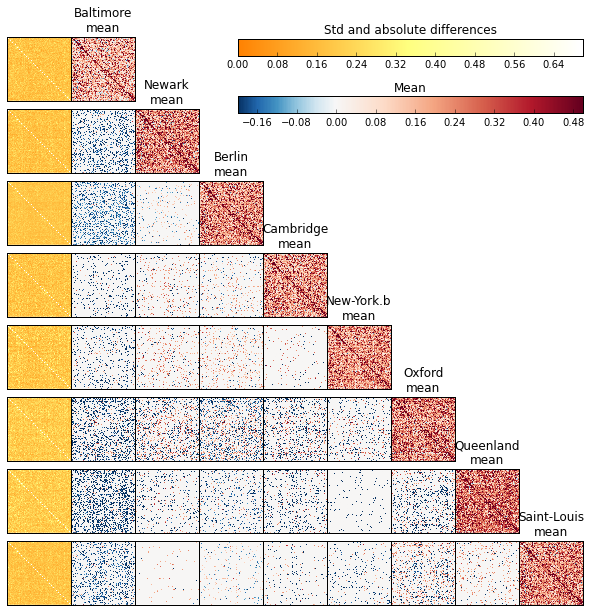

In [152]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
#reload(vis.matrix)
reload(ts)
reload(hc)

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1))

def gen_fig(list_conn_sites):
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queenland','Saint-Louis']
    lim_mean = [-0.2,0.5]
    fig = plt.figure(figsize=(16, 16))
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(1,len(list_conn_sites)+1, wspace=0.0, hspace=0.0)
    grid1.update(wspace=0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0.5)
    for sidx in range(0,len(list_conn_sites)+1):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        for site_diff_idx in range(0,len(list_conn_sites)):
            grid2 = gridspec.GridSpecFromSubplotSpec(len(list_conn_sites),1, subplot_spec=grid1[sidx], wspace=0.0, hspace=0.0)
            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            #grid2.update(left=0.05, right=0.48, wspace=0.05)
            
            if sidx == 0:
                # include the last std at the end of the 
                site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
                ax2 = plt.subplot(grid2[site_diff_idx,:])
                vis.mat(hc.ordermat(site_std_tmp,order),[0,0.7],False,False)
                plt.ylabel('std')
                
            else:
                if site_diff_idx == sidx-1:

                    #plt.imshow(site_std, interpolation="none")
                    #plt.delaxes()
                    ax1 = plt.subplot(grid2[site_diff_idx,:])
                    vis.mat(hc.ordermat(site_mean,order),lim_mean,False,False)
                    plt.title(site_names[sidx-1] + '\nmean')

                    """
                    if (sidx!=0):
                        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx-1])
                        ax2 = plt.subplot(grid2[site_diff_idx-1,:])
                        vis.matrix.mat(site_std_tmp,[0,0.5],False,False)
                        plt.title('std')
                    """

                elif site_diff_idx > sidx-1:
                    conn_vec_tmp = list_conn_sites[site_diff_idx]
                    #t, prob = scipy.stats.ttest_ind(conn_vec,conn_vec_tmp)
                    t,pval = stats.ttest_ind(conn_vec,conn_vec_tmp, axis=1, equal_var = False)
                    rejected , pvaluecorrected = fdr(pval,0.05)
                    rejected = ts.vec2mat(rejected)
                    site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
                    ax3 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.mat(hc.ordermat(np.abs(site_mean - site_mean_tmp),order),lim_mean,False,False)
                    vis.mat(hc.ordermat((site_mean - site_mean_tmp)*rejected ,order),lim_mean,False,False)

    # include the color bars 1
    lim = [0,0.7]
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.2, 0.48, 0.3, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Std and absolute differences')

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.2, 0.43, 0.3, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean')
    #plt.tight_layout()
    #plt.savefig(path_out + file_out)
    #plt.show()
                

gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



## Matrix glass brain

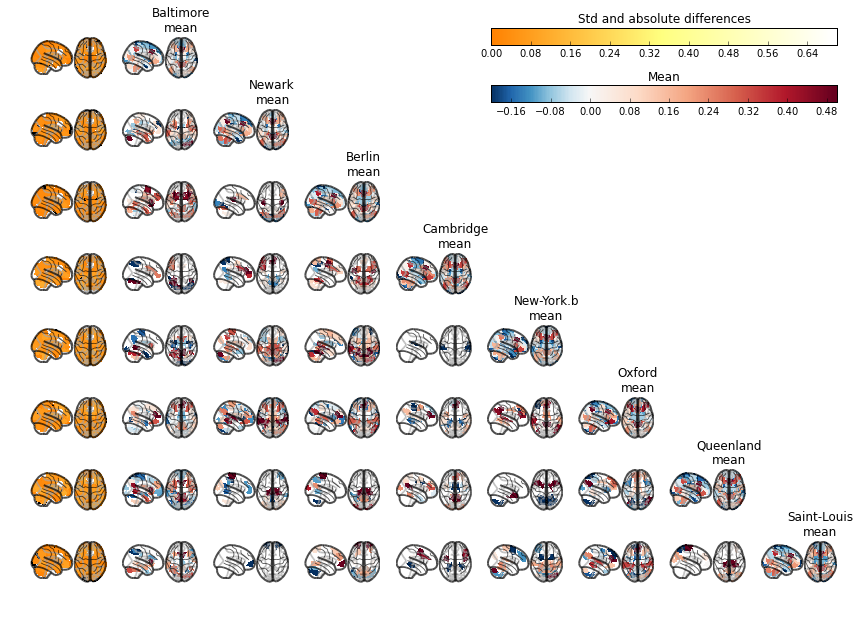

In [209]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
#reload(vis.matrix)
reload(ts)
reload(hc)
import copy
import nilearn
from nilearn import plotting
import nibabel as nib

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map



def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1))

def gen_fig_gb(list_conn_sites):
    
    selected_network_idx = 1
    
    im_ref = nib.load('basc_cambridge_sc100.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queenland','Saint-Louis']
    lim_mean = [-0.2,0.5]
    lim_std = [0,0.7]
    fig = plt.figure(figsize=(16, 16))
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(1,len(list_conn_sites)+1, wspace=0.0, hspace=0.0)
    grid1.update(wspace=0.2, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0.7)
    for sidx in range(0,len(list_conn_sites)+1):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        for site_diff_idx in range(0,len(list_conn_sites)):
            grid2 = gridspec.GridSpecFromSubplotSpec(len(list_conn_sites),1, subplot_spec=grid1[sidx], wspace=0.0, hspace=0.0)
            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            #grid2.update(left=0.05, right=0.48, wspace=0.05)
            
            if sidx == 0:
                # include the last std at the end of the 
                site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
                ax2 = plt.subplot(grid2[site_diff_idx,:])
                #vis.mat(hc.ordermat(site_std_tmp,order),[0,0.7],False,False)
                nn_map = mapvec(site_std_tmp[selected_network_idx,:],im_ref)
                plotting.plot_glass_brain(nn_map,
                                          cmap=vis.get_cmap(nn_map.get_data(),lim_std),
                                          annotate=False,
                                          axes=ax2,
                                          colorbar=False ,
                                          display_mode='xz'
                                         )
                plt.ylabel('std')
                
            else:
                if site_diff_idx == sidx-1:

                    #plt.imshow(site_std, interpolation="none")
                    #plt.delaxes()
                    ax1 = plt.subplot(grid2[site_diff_idx,:])
                    
                    #vis.mat(hc.ordermat(site_mean,order),lim_mean,False,False)
                    nn_map = mapvec(site_mean[selected_network_idx,:],im_ref)
                    plotting.plot_glass_brain(nn_map,
                                              cmap=vis.get_cmap(nn_map.get_data(),lim_mean),
                                              annotate=False,
                                              axes=ax1,
                                              colorbar=False ,
                                              display_mode='xz'
                                             )
                    plt.title(site_names[sidx-1] + '\nmean')

                    """
                    if (sidx!=0):
                        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx-1])
                        ax2 = plt.subplot(grid2[site_diff_idx-1,:])
                        vis.matrix.mat(site_std_tmp,[0,0.5],False,False)
                        plt.title('std')
                    """

                elif site_diff_idx > sidx-1:
                    conn_vec_tmp = list_conn_sites[site_diff_idx]
                    #t, prob = scipy.stats.ttest_ind(conn_vec,conn_vec_tmp)
                    t,pval = stats.ttest_ind(conn_vec,conn_vec_tmp, axis=1, equal_var = False)
                    rejected , pvaluecorrected = fdr(pval,0.05)
                    rejected = ts.vec2mat(rejected)
                    site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
                    ax3 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.mat(hc.ordermat((site_mean - site_mean_tmp)*rejected ,order),lim_mean,False,False)
                    
                    nn_map = mapvec(((site_mean - site_mean_tmp)*rejected)[selected_network_idx,:],im_ref)
                    plotting.plot_glass_brain(nn_map,
                                              cmap=vis.get_cmap(nn_map.get_data(),lim_mean),
                                              annotate=False,
                                              axes=ax3,
                                              colorbar=False ,
                                              display_mode='xz'
                                             )

    # include the color bars 1
    lim = lim_std
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.4, 0.48, 0.3, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Std and absolute differences')

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.4, 0.43, 0.3, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean')
    #plt.tight_layout()
    #plt.savefig(path_out + file_out)
    #plt.show()
                

gen_fig_gb(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)





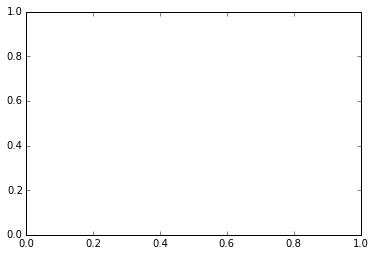

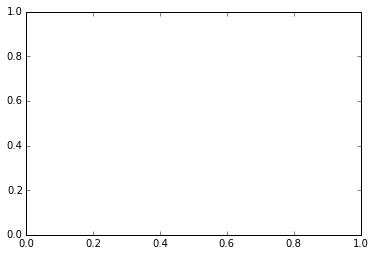

In [146]:
data_tmp = scipy.io.loadmat('/Users/christian/cobre/cobre_vols_all.mat')
partition = data_tmp['partition']
reload(ts)
site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)

        
vec_map = site_mean[1,:]

dm_vol = ts.vec2vol(vec_map,partition[:,:,:,5])
dm_vol.shape



In [103]:
vis.mat(dm_vol[26,:,:])
#site_mean.shape

NameError: name 'dm_vol' is not defined

In [160]:
import nilearn
from nilearn import plotting
import nibabel as nib

#im_ref = nib.load('sci100_scg100_scf100/brain_partition_consensus_group_sci100_scg100_scf100.mnc.gz')
im_ref = nib.load('basc_cambridge_sc100.mnc.gz')

#im_ref = nib.load('/Users/christian/neurorx/glm_connectome_local/sci100cambridge/effect_lhvol/data_to_del.mnc')
'''
im_ref
data = dm_vol
img = nib.Nifti1Image(data, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)
img.header.get_xyzt_units()
nib.save(img, os.path.join('build',main_path + '/test4d.nii.gz'))

from nilearn import datasets

###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]



plotting.plot_glass_brain(img,threshold=0)
#vis.mat(partition[:,:,20,5])
#gen_fig(list_conn_sites)

partition[:,:,:,4].max()


###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]

'''

###############################################################################
# demo glass brain plotting
#                          threshold=80,
plotting.plot_glass_brain(im_ref,
                          colorbar=True ,
                          threshold=1,
                          display_mode='xz'
                          
                         )

#plotting.plot_glass_brain(localizer_tmap_filename, title='plot_glass_brain',
#                          black_bg=True, display_mode='xz', threshold=3)

#import matplotlib.pyplot as plt
plt.show()

cut_coords = (0, 0, 30)

plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')
plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')


ImageFileError: Filespec "basc_cambridge_sc100.mnc.gz" does not look right for class <class 'nibabel.minc2.Minc2Image'>

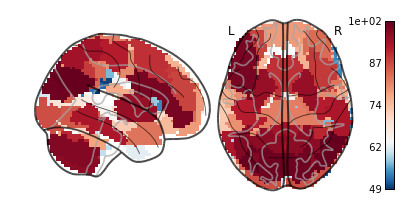

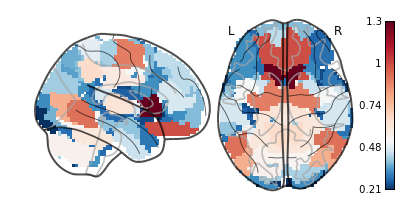

In [202]:

import copy

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def mapvec2(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        if (i+1) == 1:
            im[idxs] = 0.5
        else:
            im[idxs] = 0
        
    return new_map


im_ref = nib.load('basc_cambridge_sc100.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())

#nn_map = mapvec2(site_mean[1,:],im_ref)
#print im_ref.get_data() == nn_map.get_data()
#print(im_ref)
#print(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine()))
#print(copy.deepcopy(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())))

nn_map = mapvec(site_mean[1,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(im_ref,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )
nn_map = mapvec(site_mean[10,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(nn_map,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )



#vis.mat(img[28,:,:])

In [122]:
print im_ref
new_map = copy.deepcopy(im_ref)
print new_map.get_data()

<class 'nibabel.minc1.Minc1Image'>
data shape (46, 64, 53)
affine: 
[[   0.    0.    3.  -78.]
 [   0.    3.    0. -112.]
 [   3.    0.    0.  -50.]
 [   0.    0.    0.    1.]]
metadata:
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0

Exception AttributeError: "'GzipFile' object has no attribute 'fileobj'" in <bound method netcdf_file.close of <nibabel.externals.netcdf.netcdf_file object at 0x10bdab950>> ignored


In [15]:
localizer_tmap_filename

'/Users/christian/nilearn_data/brainomics_localizer/brainomics_data/S02/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz'

In [ ]:
0.2/(0.2+1.2)

a=np.array([1,2,3])
n=3
(2**(n+4))+n

(16*n)+2*n+1

frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(True)
frame1.axes.get_yaxis()
        


In [ ]:
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, 1:1+2])
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

In [59]:
from scipy import stats
reload(vis.matrix)
t, prob = stats.ttest_ind(list_conn_sites[1],list_conn_sites[5],1,equal_var=False)
t, prob

vis.matrix.mat(ts.vec2mat(prob)*(ts.vec2mat(prob)<0.001))

cmap = vis.matrix.get_cmap(prob,[0,1])

import matplotlib as mpl
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_axes([0.8, 0.05, 0.1, 0.9])
vis.matrix.color_bar_vertical(ax1, cmap, [0,1])
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.1])
vis.matrix.color_bar_horizontal(ax1, cmap, [0,1])

plt.subplot(grid2[0, :])

2+2

TypeError: reload() argument must be module

In [ ]:
2+2